###  MicroGrad sparse demo

In [14]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP, Module

In [16]:
class SparseNeuron(Module):

    def __init__(self, nin, sparsity, nonlin=True):
        assert 0 <= sparsity < 1
        n_weights = math.ceil((1 - sparsity) * nin)
        w_indices = random.sample(range(n_weights), k=n_weights)
        self.w = {i: Value(random.uniform(-0.1, 0.1)) for i in w_indices}
        self.b = Value(0)
        self.nonlin = nonlin
        self.zero_ws = {}

    def __call__(self, x, dense_grad=False):
        if dense_grad:
            # We need to calculate all gradients therefore introduce zeros.
            self.zero_ws = {}
            results = []
            for i, xi in enumerate(x):
                if i in self.w:
                    results.append(self.w[i]*xi)
                else:
                    self.zero_ws[i] = Value(0)
                    results.append(self.zero_ws[i]*xi)

            act = sum(results, self.b)
            return act.relu() if self.nonlin else act
        else:
            act = sum((wi*x[i] for i, wi in self.w.items()), self.b)
            return act.relu() if self.nonlin else act        
    
    def parameters(self):
        return list(self.w.values()) + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"
    
class SparseLayer(Module):

    def __init__(self, nin, nout, sparsity=0, **kwargs):
        self.neurons = [SparseNeuron(nin, sparsity, **kwargs) for _ in range(nout)]

    def __call__(self, x, dense_grad=False):
        out = [n(x, dense_grad=dense_grad) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class SparseMLP(Module):

    def __init__(self, nin, nouts, sparsities):
        sz = [nin] + nouts
        self.layers = [SparseLayer(sz[i], sz[i+1], sparsity=sparsities[i],
                                   nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x, dense_grad=False):
        for layer in self.layers:
            x = layer(x, dense_grad=dense_grad)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [22]:
np.random.seed(1337)
random.seed(1337)

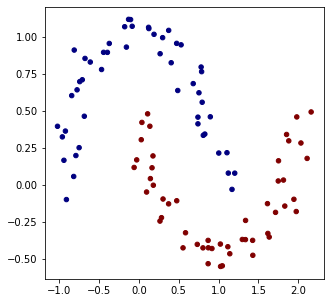

In [23]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [24]:
from functools import partial
# loss function
def loss(model, batch_size=None, dense_grad=False):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(partial(model, dense_grad=dense_grad), inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

# total_loss, acc = loss()
# print(total_loss, acc)
# total_loss, acc = loss(dense_grad=True)
# print(total_loss, acc)
# print(model.layers[0].neurons[0].zero_ws)

In [25]:
def top_k_param_dict(param_tuples, k, sort_fn=lambda p: abs(p.data)):
    # The list has (param, index, ..) tuples, so we apply function to the param.
    key_fn = lambda tp: sort_fn(tp[0])
    # We can do top_k(k=n_update), but for now we are sorting it all.
    sorted_list = sorted(param_tuples, key=key_fn, reverse=True)
    return sorted_list[:k]

def rigl_update_neuron(model, update_fraction=0.3):
    total_loss, acc = loss(model, dense_grad=True)
    # backward
    model.zero_grad()
    total_loss.backward()
    
    for layer in model.layers:
        for neuron in layer.neurons:
            n_weights = len(neuron.w)
            n_update = math.floor(n_weights * update_fraction)
            if n_update == 0:
                # Not updating
                continue
#             print(n_update)
            # Decide connections to grow (pick top gradient magnitude).
            zero_params = [(p, i) for i, p in neuron.zero_ws.items()]
            params = [(p, i) for i, p in neuron.w.items()]
            top_grad_fn = lambda p: abs(p.grad)
            top_k_zero_params = top_k_param_dict(zero_params, n_update, sort_fn=top_grad_fn)
#             print(top_k_zero_params)
            # Find connections to drop (pick least magnitude).
            least_magnutide_fn = lambda p: -abs(p.data)
            bottom_k_params = top_k_param_dict(params, n_update, sort_fn=least_magnutide_fn)
#             print(bottom_k_params)
            for (p, i), (_, i_new) in zip(bottom_k_params, top_k_zero_params):
                # Update weights
                del neuron.w[i]
                p.data = 0.
                neuron.w[i_new] = p
            # Done with zero_params delete them.
            neuron.zero_ws = {}       
            
def rigl_update_layer(model, update_fraction=0.3):
    total_loss, acc = loss(model, dense_grad=True)
    # backward
    model.zero_grad()
    total_loss.backward()
    
    for layer in model.layers:
        n_weights = 0
        zero_params, params = [], []
        for j, neuron in enumerate(layer.neurons):
            n_weights += len(neuron.w)
            # Decide connections to grow (pick top gradient magnitude).
            zero_params.extend([(p, i, j)  for i, p in neuron.zero_ws.items()])
            params.extend([(p, i, j)  for i, p in neuron.w.items()])
            # Done with zero_params delete them.
            neuron.zero_ws = {}       
        n_update = math.floor(n_weights * update_fraction)
        if n_update == 0:
            # Not updating
            continue

        top_grad_fn = lambda p: abs(p.grad)
        top_k_zero_params = top_k_param_dict(zero_params, n_update, sort_fn=top_grad_fn)
#         print(top_k_zero_params)
        # Find connections to drop (pick least magnitude).
        least_magnutide_fn = lambda p: -abs(p.data)
        bottom_k_params = top_k_param_dict(params, n_update, sort_fn=least_magnutide_fn)
#         print(bottom_k_params)
        for (p, i, j), (_, i_new, j_new) in zip(bottom_k_params, top_k_zero_params):
            # Update weights
            del layer.neurons[j].w[i]
#             if not layer.neurons[j].w:
#                 del layer.neurons[j]
            p.data = 0.
            layer.neurons[j_new].w[i_new] = p

        
#             print(n_update)

def rigl_update_model(model, update_fraction=0.3):
    total_loss, acc = loss(model, dense_grad=True)
    # backward
    model.zero_grad()
    total_loss.backward()
    n_weights = 0
    zero_params, params = [], []
    for k, layer in enumerate(model.layers):
        for j, neuron in enumerate(layer.neurons):
            n_weights += len(neuron.w)
            # Decide connections to grow (pick top gradient magnitude).
            zero_params.extend([(p, i, j, k)  for i, p in neuron.zero_ws.items()])
            params.extend([(p, i, j, k)  for i, p in neuron.w.items()])
            # Done with zero_params delete them.
            neuron.zero_ws = {}       
    n_update = math.floor(n_weights * update_fraction)
    if n_update == 0:
        # Not updating
        return
    top_grad_fn = lambda p: abs(p.grad)
    top_k_zero_params = top_k_param_dict(zero_params, n_update, sort_fn=top_grad_fn)
#     print(top_k_zero_params)
    # Find connections to drop (pick least magnitude).
    least_magnutide_fn = lambda p: -abs(p.data)
    bottom_k_params = top_k_param_dict(params, n_update, sort_fn=least_magnutide_fn)
#     print(bottom_k_params)
#     import pdb; pdb.set_trace()
    for (p, i, j, k), (_, i_new, j_new, k_new) in zip(bottom_k_params, top_k_zero_params):
        # Update weights
        del model.layers[k].neurons[j].w[i]
#         if not model.layers[k].neurons[j].w:
#             del model.layers[k].neurons[j]
        p.data = 0.
        model.layers[k_new].neurons[j_new].w[i_new] = p

        
#             print(n_update)

In [26]:
# initialize a model 
model = SparseMLP(2, [16, 16, 1], [0.8]*3) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(1), ReLUNeuron(1), ReLUNeuron(1), ReLUNeuron(1), ReLUNeuron(1), ReLUNeuron(1), ReLUNeuron(1), ReLUNeuron(1), ReLUNeuron(1), ReLUNeuron(1), ReLUNeuron(1), ReLUNeuron(1), ReLUNeuron(1), ReLUNeuron(1), ReLUNeuron(1), ReLUNeuron(1)], Layer of [ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4)], Layer of [LinearNeuron(4)]]
number of parameters 117


In [27]:
# optimization
import time 
start_time = time.time()
# optimization
N_TOTAL=400
for k in range(400):
    
    # forward
    total_loss, acc = loss(model)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1 - 0.9*k/N_TOTAL
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
#         if k != 0: rigl_update_model(model, update_fraction=learning_rate*0.4)
print(time.time()-start_time)

step 0 loss 0.9997557727304812, accuracy 73.0%
step 10 loss 0.9937546224113598, accuracy 67.0%
step 20 loss 0.7666823249680883, accuracy 73.0%
step 30 loss 0.6078497770807276, accuracy 66.0%
step 40 loss 0.5965460898918176, accuracy 66.0%
step 50 loss 0.5945907012524915, accuracy 66.0%
step 60 loss 0.592033775607312, accuracy 66.0%
step 70 loss 0.5908906863963095, accuracy 67.0%
step 80 loss 0.5868539814745729, accuracy 66.0%
step 90 loss 0.5842953217923167, accuracy 71.0%
step 100 loss 0.5823271844830642, accuracy 71.0%
step 110 loss 0.5781990234262636, accuracy 72.0%
step 120 loss 0.5744694406032917, accuracy 73.0%
step 130 loss 0.5696349317122807, accuracy 73.0%
step 140 loss 0.5659029089641983, accuracy 73.0%
step 150 loss 0.5621051276302161, accuracy 73.0%
step 160 loss 0.5596968923908787, accuracy 73.0%
step 170 loss 0.556277712483224, accuracy 73.0%
step 180 loss 0.5518287638199755, accuracy 73.0%
step 190 loss 0.5463636686423629, accuracy 74.0%
step 200 loss 0.5422332975817247,

(-1.548639298268643, 1.951360701731357)

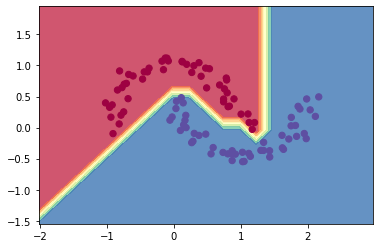

In [44]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
